# Neural Network Model

In [ ]:
from collections import namedtuple
from sklearn.model_selection import KFold
import pickle
import itertools
import warnings
import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, average_precision_score, auc, roc_auc_score, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_path = '/kaggle/input/foodcom-recipes-and-reviews/'
text_path ='/kaggle/input/recipe-get-embeddings/'
image_path = '/kaggle/input/fork-of-get-image-ebeddings2/'

In [ ]:
def get_summary_cols(df):
    ret = []
    for c in get_summary(df.head(1)):
        if 'time' in c.lower():
            ret.append(c)
        else:
            ret.append(f'{c}_len')
    return ret

def get_top(train, col, k):

    if isinstance(k, int):
        filter_expr = pl.col('count')>=k
    elif  isinstance(k, float):
        filter_expr = pl.col('count')>=pl.col('count').get((k*pl.len()).cast(pl.UInt64))
    top = train.select(
        col
    ).explode(
        col
    ).collect(
    )[
        col
    ].value_counts(
    ).drop_nulls(
    ).sort(
        'count',descending=True
    ).filter(
        filter_expr
    # ).with_row_index(
    )
    top = list(np.hstack([top[col].to_numpy(), 'other']))

    return top

def get_top(train, col, k):

    if isinstance(k, int):
        filter_expr = pl.col('count')>=k
    elif  isinstance(k, float):
        filter_expr = pl.col('count')>=pl.col('count').get((k*pl.len()).cast(pl.UInt64))
    top = train.select(
        col
    ).explode(
        col
    ).collect(
    )[
        col
    ].value_counts(
    ).drop_nulls(
    ).sort(
        'count',descending=True
    ).filter(
        filter_expr
    # ).with_row_index(
    )
    top = list(np.hstack([top[col].to_numpy(), 'other']))

    return top

def process_X_col(df, col, top):

    return pl.col(col).list.eval(
        pl.when(
            pl.element().is_in(top)
        ).then(
            pl.element()
        ).otherwise(
            pl.lit('other')
        ).replace(top, np.arange(len(top))).cast(pl.Int32)
    )

def to_sparse(df, col):
    arr = df.select(
        'index',
        col
    ).explode(
        col
    ).with_columns(
        (pl.col(col).cum_count().alias('y')).over('index')
    ).filter(
        pl.col(col).is_not_null()
    ).collect(
    ).to_pandas(
    )

    return sparse.coo_array((arr[col], (arr['index'], arr['y']))).tocsr()

def extract_duration(col):
    hours = pl.col(col).str.extract('(\d+)H').cast(pl.Int64).fill_null(0)
    minutes = pl.col(col).str.extract('(\d+)M').cast(pl.Int64).fill_null(0)
    duration = (hours * 60 + minutes).alias(col)

    return duration
#     return pl.when(duration!=0).then(duration)

def isin_list(df, col, values, index_col):

    return df.select(
        index_col,
        pl.col(col).list.set_intersection(values)
    ).with_row_count(
    ).explode(
        'Keywords'
    ).collect(
    ).to_dummies(
        'Keywords'
    ).lazy(
    ).group_by(
        'RecipeId'
    ).agg(
        pl.all(
            ).cast(
                pl.Boolean
            ).any(
        )
    )

def get_sparse_cols(df, X_cols, tops):
    data = df.select(
        'index',
        *[process_X_col(df, col, tops[col]) for col in X_cols]
    )
    X = {col: to_sparse(data, col) for col in X_cols}
#     y = data.select(y_col).collect()[y_col].to_numpy()

    return X

def get_summary(df, scaler=None, log=True, exclude=None):

    df = df.select(
        pl.col('Name').str.split(' ').list.len(),
        pl.col('Description').str.split(' ').list.len(),
        pl.col('Images').list.len(),
        pl.col('Keywords').list.len(),
        pl.col('RecipeIngredientParts').list.len(),
        pl.col('RecipeInstructions').list.len(),
        extract_duration('CookTime'),
        extract_duration('PrepTime'),
        extract_duration('TotalTime'),
    )
    if exclude is not None:
        df = df.select(pl.exclude(exclude))
    if log:
        df = df.select((pl.all()+1).log())
    arr = df.collect().to_pandas()
    if scaler is None:
        return arr
    else:
        try:

            return scaler.transform(arr)
        except AttributeError:

            return scaler.fit_transform(arr)

def get_y(df):

    return df.select(
        (pl.col('AggregatedRating').fill_null(1)>=4).cast(pl.Float32)
    ).collect().to_numpy()

In [ ]:
class Loader:
    def __init__(self, X, y, types, batch_size=None, seed=None, ids=False, device='cpu', dtype=torch.float32, shuffle=True):
        self.X = X
        self.y = y
        self.types = types
        self.batch_size = batch_size
        self.rng = np.random.default_rng(seed)
        self.ix_arr = np.arange(y.shape[0])
        self.ids = ids
        self.device = device
        self.dtype = dtype
        self.shuffle = shuffle
    def __iter__(self):
        if self.shuffle:
            self.rng.shuffle(self.ix_arr)
        self.splits = iter(np.array_split(self.ix_arr, len(self)))
        return self
    def __next__(self):
        ix=next(self.splits)
        if self.batch_size is None:
            X = self.X
            y = self.y
        else:
            X = {k:v[ix] for k, v in self.X.items()}
            y = self.y[ix]

        X = {k:self.get_X(k, v) for k, v in X.items()}
        return X, self.to_tensor(y)
    def __len__(self):
        return self.y.shape[0]//self.batch_size+1

    def _flatten(self, X):
        ret = {}
        X.eliminate_zeros()
        ret['input'] = self.to_tensor(X.data, dtype=torch.int32)
        offsets = np.hstack((0, X.astype(bool).sum(1).cumsum()[:-1]))
        ret['offsets'] = self.to_tensor(offsets, dtype=torch.int32)
        return ret

    def to_tensor(self, arr, device=None, dtype=None):
        device = self.device if device is None else device
        dtype = self.dtype if dtype is None else dtype
        return torch.tensor(arr, device=device, dtype=dtype)

    def get_X(self, key, v):
        if self.types[key] == 'bag':
            return self._flatten(v)
        else:
            return self.to_tensor(v)

In [ ]:
def create_mlp(hidden_size, n_layers=1):
    layers = []
    for _ in range(n_layers):
        layers.extend((nn.LazyLinear(hidden_size), nn.Dropout(), nn.ReLU()))
    return nn.Sequential(*layers)

class Net(nn.Module):
    def __init__(self, input_sizes, types, hidden_size, bagdim=16, n_layers=0, mode='mean', scale_grad_by_freq=False):
        super().__init__()
        self.keys = sorted(types)
        self.types = types
        self.first = {}
        self.input_sizes = input_sizes
        self.hidden_size = hidden_size
        self.bagdim = bagdim
        self.mode = mode
        self.scale_grad_by_freq = scale_grad_by_freq
        self.input_drop = nn.Dropout(.2)
        for key in self.keys:
            self.create_sub(key)
        self.drop = nn.Dropout()
        self.relu = nn.ReLU()
        self.mlp = create_mlp(hidden_size, n_layers)
        self.final = nn.LazyLinear(1)
        self.embedding_keys = {}

    def forward(self, *args, **kwargs):
        if args:
            if len(args) == 1:
#                 X = self.unconcat(args[0])
                X = args[0]
            else:
                raise Error
        else:
            X = self.forward_first(kwargs)
            X = self.concat(X)
        X = self.input_drop(X)
#         X = self.relu(X)
        X = self.mlp(X)
        X = self.final(X)
        return X

    def concat(self, X):
        if not hasattr(self, 'sizes'):
            self.sizes = {}
            for k, v in X.items():
                tot = 0
                self.sizes[k] = slice(tot, v.shape[1] + tot)
                tot += v.shape[1]
        return torch.concat(list(X.values()), -1)

    def unconcat(self, X):
        return {k:X[:, v] for k, v in self.sizes.items()}

    def forward_first(self, X):
        return {k: self.forward_sub(k, X[k]) for k in self.keys}

    def forward_sub(self, k, X):
        if self.types[k] == 'bag':
            if isinstance(X, dict):
                return getattr(self, k)(**X)
            else:
                return getattr(self, k)(X)
        else:
            return getattr(self, k)(X)

    def create_sub(self, k):
        if self.types[k] == 'bag':
#             sub = nn.EmbeddingBag(self.input_sizes[k], self.hidden_size)
            sub = nn.EmbeddingBag(self.input_sizes[k], self.bagdim, padding_idx=0)
        elif self.types[k] == 'emb':
            sub = nn.Sequential()
        else:
#             sub = nn.LazyLinear(self.hidden_size)
            sub = nn.Sequential()
        setattr(self, k, sub)
        self.first[k] = sub
        return sub

In [ ]:
class Trainer:
    def __init__(self, default_params, param_grid, types, batch_size, df, emb_dfs, im_df=None, exclude=None):
        Params = namedtuple(
            'params',
            default_params,
            defaults=default_params.values()
        )
        self.params = [Params(**dict(zip(param_grid, p))) for p in itertools.product(*list(param_grid.values()))]
        if len(self.params) == 0:
            self.params=[Params()]
        self.losses = {}
        self.scores = {}
        self.models = {}
        self.best = {}
        self.input_sizes = {}
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.batch_size = batch_size
        self.types = types
        self.df = df
        self.emb_dfs = emb_dfs
        self.im_df = im_df
        self.exclude = exclude

    def fit(self, epochs, n=5, refit=True, eval_steps=None, max_steps=np.inf):
        recipes = df.select('RecipeId').collect().to_numpy().ravel()
        if n > 0:
            kfold = KFold(5, random_state=0, shuffle=True)
            for i, splits in enumerate(kfold.split(recipes)):
                self.losses[i] = {}
                self.scores[i] = {}
                self.models[i] = {}
                self.best[i] = {}
                train_dl, test_dl = self.create_dls(splits)
                input_sizes = self.get_input_sizes(train_dl)
                if eval_steps is None:
                    eval_steps = len(train_dl) // 5
                self.input_sizes[i] = input_sizes
    #             for p in self.params:
                for p in tqdm(self.params):
                    best_score = {'acc':0}
                    losses = []
                    try:
                        model = self.models[i][str(p)].to(device)
                    except KeyError:
                        with warnings.catch_warnings():
                            warnings.filterwarnings('ignore', 'Lazy modules', category=UserWarning)
                            model = Net(input_sizes, self.types, p.hs, n_layers=p.n_layers, bagdim=p.bagdim).to(device)
                    optimizer = optim.AdamW(model.parameters(), p.lr)
                    for epoch in range(epochs):
    #                 for epoch in tqdm(range(epochs)):
                        for j, (X, y) in enumerate(train_dl):
    #                     for X, y in train_dl:
                            self.train(model, X, y, optimizer, losses)
                            if j % (eval_steps-1) == 0:
                                step = j + epoch * len(train_dl)
                                scores = self.eval(model, test_dl, step)
                                if scores['acc'] > best_score['acc']:
                                    best_score = scores
                                    best = step
                    model.embedding_keys = self.tops
                    self.scores[i][str(p)] = best_score
                    self.best[i][str(p)] = best
                    self.losses[i][str(p)] = losses
                    self.models[i][str(p)] = model.to('cpu')
                if i + 1 == n:
                    break
            with open('scores', 'wb') as f:
                pickle.dump(self.scores, f)
            with open('losses', 'wb') as f:
                pickle.dump(self.losses, f)
            return self.scores, self.losses

        else:
            train_dl = list(self.create_dls([recipes]))[0]
            input_sizes = self.get_input_sizes(train_dl)
            self.input_sizes = input_sizes
            p = self.params[0]
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', 'Lazy modules', category=UserWarning)
                model = Net(input_sizes, self.types, p.hs, n_layers=p.n_layers, bagdim=p.bagdim).to(device)
            optimizer = optim.AdamW(model.parameters(), p.lr)
            losses = []
#             return train_dl
#             for epoch in range(epochs):
            for epoch in (range(epochs)):
                for j, (X, y) in enumerate(tqdm(train_dl)):
                    self.train(model, X, y, optimizer, losses)
                    if (j + epoch * len(train_dl)) > max_steps:
                        break
            self.dl = train_dl
            self.losses = losses
            model.embedding_keys = self.tops
            self.model = model
            return model

    def train(self, model, X, y, optimizer, losses):
        model.train()
        preds = model(**X)
        loss = self.loss_fn(preds, y)#.view(-1,1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(float(loss))

    def eval(self, model, dl, step):
        ps, ys = [], []
        with torch.no_grad():
            model.eval()
            for i,(X,y) in enumerate(dl):
                ys.append(y)
                ps.append(model(**X))
        y = torch.vstack(ys).flatten().cpu().numpy()
        preds = torch.vstack(ps).flatten().cpu().numpy()
        return {
            'step':step,
            'ap': average_precision_score(y, preds),
            'acc': accuracy_score(y, preds>0),
            'auc': roc_auc_score(y, preds),
        }

    def create_dls(self, spls):
        scaler = StandardScaler()
        dfs = {}
        dls = {}
        for name, spl in dict(zip(('train', 'test'), spls)).items():
            df = self.df.filter(pl.col('RecipeId').is_in(spl)).with_row_index()
            dfs[name] = df
            ix = df.sort('index').select('RecipeId').collect().to_numpy().ravel()
            X = {k:v.loc[ix].values for k, v in self.emb_dfs.items()}
            if self.im_df is not None:
                X['images'] = self.im_df.reindex(ix, fill_value=0).values
            X['summary'] = get_summary(df, scaler, exclude=self.exclude)
            if not hasattr(self, 'tops'):
                self.tops = {col:get_top(dfs['train'], col, 20) for col in ('RecipeIngredientParts', 'Keywords')}
            X.update(get_sparse_cols(df, ('RecipeIngredientParts', 'Keywords'), self.tops))
            X = {k:X[k] for k in X if k in self.types}
            y = get_y(df)
            dls[name] = Loader(X, y, self.types, self.batch_size, 0, device=device)
#             print(X.keys())
        return dls.values()

    def get_input_sizes(self, train_dl):
        X = train_dl.X
        input_sizes = {k: v.max()+2 for k, v in X.items() if self.types[k] == 'bag'}
        input_sizes.update({k: v.shape[1] for k, v in X.items() if self.types[k] != 'bag'})
        return input_sizes

In [ ]:
covnet = None
covnet = 'clip-ViT-B-32'

In [ ]:
embs = (
    'names',
    'Description',
    'instructions'
)

In [ ]:
types = {
    'summary':'linear',
    'RecipeIngredientParts':'bag',
    'Keywords':'bag'
}
types.update({emb:'emb' for emb in embs})
if covnet is not None:
    types['images'] = 'emb'

In [ ]:
df = pl.scan_parquet(data_path+'recipes.parquet')
emb_dfs = {emb:pd.read_parquet(text_path+f'{emb}.parquet') for emb in embs}
if covnet is None:
    im_df = None
else:
    im_df = pd.read_parquet(image_path+f'{covnet}.parquet')

In [ ]:
param_defaults = {
    'hs':2**8,
    'n_layers':1,
    'lr':.01,
    'bagdim':16,
}

In [ ]:
param_grid = {
    'hs':[2**6,2**10],
    'n_layers':[1, 2],
}

# Grid Search CV

We did many more searches over many more parameters and values. This is just for example only.

In [ ]:
trainer = Trainer(
    default_params=param_defaults,
    param_grid=param_grid,
    types=types,
    batch_size=2**10,
    df=df,
    emb_dfs=emb_dfs,
    im_df=im_df
)
scores, losses = trainer.fit(2,5)

100%|██████████| 4/4 [02:59<00:00, 44.78s/it]


In [ ]:
results_df = pd.concat({k:pd.DataFrame(v) for k,v in scores.items()}).stack()
results_df.index.names = 'split', 't', 'params'
results_df.unstack(1).groupby('params').mean()

t,step,ap,acc,auc
params,,,,
"params(hs=1024, n_layers=1, lr=0.01, bagdim=16)",623.4,0.817397,0.729596,0.794750
"params(hs=1024, n_layers=2, lr=0.01, bagdim=16)",671.4,0.816552,0.728456,0.793891
"params(hs=64, n_layers=1, lr=0.01, bagdim=16)",686.8,0.817487,0.728842,0.794224
"params(hs=64, n_layers=2, lr=0.01, bagdim=16)",609.8,0.816379,0.728452,0.792913


# Feature Ablation

In [ ]:
scores = {}
summary_cols = get_summary_cols(df)
for feature in ['All_images', *list(types), *summary_cols]:
    print(feature)
    new = dict(types)
    exclude = None
    if feature in summary_cols:
        exclude = feature
    elif feature == 'All_images':
        exclude = 'Images_len'
        del new['images']
    elif feature in types:
        del new[feature]
    trainer = Trainer(
        default_params=param_defaults,
        param_grid={},
        types=new,
        batch_size=2**10,
        df=df,
        emb_dfs=emb_dfs,
        im_df=im_df,
        exclude=exclude
    )
    res = trainer.fit(2, 5, max_steps=687)[0]
    p = list(res[0])[0]
    scores[feature] = {k:v[p] for k, v in res.items()}

All_images


100%|██████████| 1/1 [00:32<00:00, 32.89s/it]


summary


100%|██████████| 1/1 [00:44<00:00, 44.61s/it]


RecipeIngredientParts


100%|██████████| 1/1 [00:44<00:00, 44.06s/it]


Keywords


100%|██████████| 1/1 [00:44<00:00, 44.48s/it]


names


100%|██████████| 1/1 [00:36<00:00, 36.23s/it]


Description


100%|██████████| 1/1 [00:35<00:00, 35.70s/it]


instructions


100%|██████████| 1/1 [00:37<00:00, 37.79s/it]


images


100%|██████████| 1/1 [00:36<00:00, 36.00s/it]


Name_len


100%|██████████| 1/1 [00:47<00:00, 47.67s/it]


Description_len


100%|██████████| 1/1 [00:47<00:00, 47.98s/it]


Images_len


100%|██████████| 1/1 [00:49<00:00, 49.03s/it]


Keywords_len


100%|██████████| 1/1 [00:49<00:00, 49.20s/it]


RecipeIngredientParts_len


100%|██████████| 1/1 [00:49<00:00, 49.12s/it]


RecipeInstructions_len


100%|██████████| 1/1 [00:49<00:00, 49.09s/it]


CookTime


100%|██████████| 1/1 [00:49<00:00, 49.56s/it]


PrepTime


100%|██████████| 1/1 [00:49<00:00, 49.75s/it]


TotalTime


100%|██████████| 1/1 [00:49<00:00, 49.80s/it]


In [ ]:
ablation_df

step        ap       acc       auc
feature    split                                     
All_images 0      394.0  0.814632  0.728433  0.791861
           1      702.0  0.814667  0.727119  0.792910
           2      626.0  0.813547  0.727247  0.791256
           3      779.0  0.817089  0.729936  0.795976
           4      779.0  0.817116  0.732192  0.797615
...                 ...       ...       ...       ...
TotalTime  0      548.0  0.817474  0.728403  0.793797
           1      702.0  0.816067  0.727397  0.793317
           2      780.0  0.817508  0.727951  0.794186
           3      779.0  0.818724  0.731027  0.795672
           4      702.0  0.818392  0.730685  0.796159

[85 rows x 4 columns]

In [ ]:
ablation_df

,feature,split,step,ap,acc,auc
0,All_images,0,394.0,0.814632,0.728433,0.791861
1,All_images,1,702.0,0.814667,0.727119,0.792910
2,All_images,2,626.0,0.813547,0.727247,0.791256
3,All_images,3,779.0,0.817089,0.729936,0.795976
4,All_images,4,779.0,0.817116,0.732192,0.797615
...,...,...,...,...,...,...
80,TotalTime,0,548.0,0.817474,0.728403,0.793797
81,TotalTime,1,702.0,0.816067,0.727397,0.793317
82,TotalTime,2,780.0,0.817508,0.727951,0.794186
83,TotalTime,3,779.0,0.818724,0.731027,0.795672


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Accuracy', ylabel='Left-out Feature'>

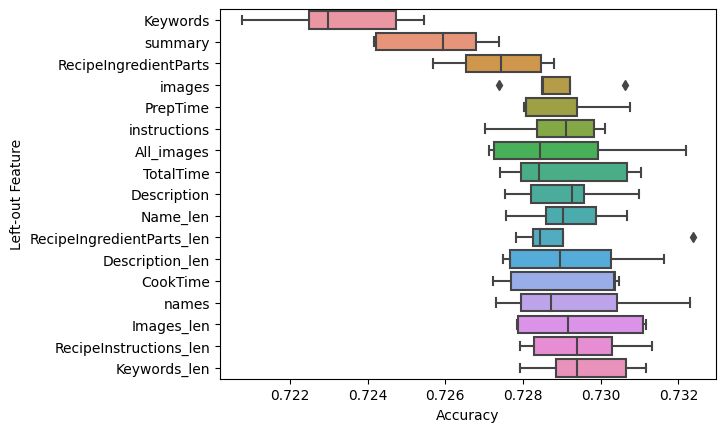

In [ ]:
ablation_df=pd.concat({k:pd.DataFrame(v) for k,v in scores.items()}).stack().unstack(1)
ablation_df.index.names = ['feature', 'split']
# ablation_df.to_csv('feature ablation results.csv')
ablation_df = ablation_df.reset_index()

ablation_df.split = ablation_df.split.astype(pd.CategoricalDtype())
sorted_features = ablation_df.groupby('feature')['acc'].mean().sort_values().index
ablation_df.feature = ablation_df.feature.astype(pd.CategoricalDtype())
ablation_df.feature = ablation_df.feature.cat.reorder_categories(sorted_features, ordered=True)
ablation_df.columns = ['Left-out Feature', 'split', 'step', 'ap', 'Accuracy', 'auc']
sns.boxplot(ablation_df, x='Accuracy', y='Left-out Feature');

In [ ]:
ablation_df.groupby('Left-out Feature')['Accuracy'].mean().sort_values()

/tmp/ipykernel_34/1970248301.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ablation_df.groupby('Left-out Feature')['Accuracy'].mean().sort_values()


Left-out Feature
Keywords                     0.723290
summary                      0.725699
RecipeIngredientParts        0.727383
images                       0.728845
PrepTime                     0.728868
instructions                 0.728886
All_images                   0.728985
TotalTime                    0.729093
Description                  0.729104
Name_len                     0.729152
RecipeIngredientParts_len    0.729188
Description_len              0.729197
CookTime                     0.729221
names                        0.729336
Images_len                   0.729428
RecipeInstructions_len       0.729439
Keywords_len                 0.729594
Name: Accuracy, dtype: float64

# Failure Analysis

In [ ]:
trainer = Trainer(
    default_params=param_defaults,
    param_grid={},
    types=types,
    batch_size=2**10,
    df=df,
    emb_dfs=emb_dfs,
    im_df=im_df
)
model = trainer.fit(2,0, max_steps=687)

 35%|███▍      | 177/511 [00:13<00:24, 13.51it/s]


In [ ]:
with open('dl','wb') as f:
    pickle.dump(trainer.dl,f)
torch.save(model,'model')

In [ ]:
trainer.eval(model, trainer.dl, 0)

{'step': 0,
 'ap': 0.811002725089584,
 'acc': 0.7305255140024153,
 'auc': 0.7976317856748895}

In [ ]:
with open('dl','rb') as f:
    dl = pickle.load(f)
model = torch.load('model', map_location=device)

In [ ]:
trainer = Trainer(
    default_params=param_defaults,
    param_grid={},
    types=types,
    batch_size=2**10,
    df=df,
    emb_dfs=emb_dfs,
    im_df=im_df
)

In [ ]:
recipes = df.select('RecipeId').collect().sample(100, seed=0).to_numpy().ravel()

In [ ]:
dl, = trainer.create_dls([recipes])
dl.shuffle = False

In [ ]:
X,y = next(iter(dl))
with torch.no_grad():
    preds = model(**X).ravel().cpu().numpy()

In [ ]:
ndf = df.filter(
    pl.col('RecipeId').is_in(recipes)
).collect(
).with_columns(
    pl.lit(preds).alias('Prediction'),
#     pl.col('RecipeInstructions').list.join('\n'),
    pl.col('Images').list.len(),
    extract_duration('CookTime'),
    extract_duration('PrepTime'),
    extract_duration('TotalTime'),
    pl.col('AggregatedRating').fill_null(0),
    pl.col('Keywords').list.len(),
    pl.col('RecipeIngredientParts').list.len(),
    pl.col('RecipeInstructions').list.len(),
).select(
    pl.exclude(
        *[col for col in df.columns if 'Content' in col],
        'RecipeCategory', 'AuthorId', 'RecipeIngredientQuantities'
    )
).sort(
    'Prediction'
)

<Axes: xlabel='Prediction', ylabel='Images'>

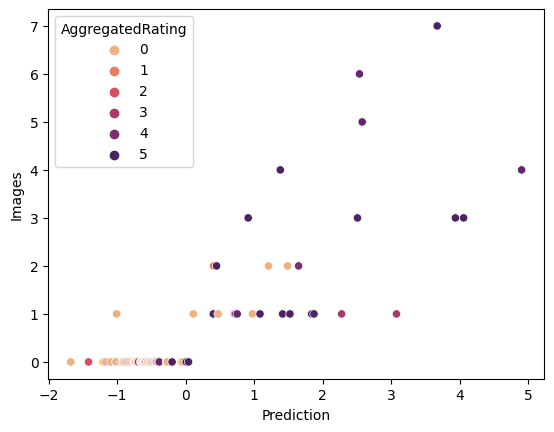

In [ ]:
sns.scatterplot(ndf.to_pandas(), x='Prediction', y='Images', hue='AggregatedRating', palette='flare')

In [ ]:
reviews = pl.scan_parquet(
    data_path+'reviews.parquet'
).with_columns(
    pl.col('RecipeId').cast(pl.Float64)
).filter(
    pl.col('RecipeId').is_in(recipes),
#     pl.col('Review').str.contains('too')
).join(
    ndf.lazy(), on='RecipeId'
).sort(
    'Prediction',descending=True
)

In [ ]:
reviews_collected = reviews.select('RecipeId','Rating','Prediction','Review').collect().sample(10)
for RecipeId,Rating,Prediction,Review in reviews_collected.iter_rows():
    print(Rating,Prediction)
    print(Review)
    print('')
    print('--------------------------------------------------------------------------------------------')
    print('')

4 3.6693756580352783
I really liked the simplicity of this recipe and the flavour is really good.  However, it is extremely sweet!  I reduced the sugar to four cups and I still found it was too sweet.  Is it possible that the amount of berries refers to the volume of crushed berries? I started with four cups fresh wild blueberries and with four cups sugar it was over the top.  I'm sure my husband will still eat it all as he has a sweet tooth, but for those who do not, be aware and reduce the sugar even more.

--------------------------------------------------------------------------------------------

5 4.055411338806152
I made this this morning and had a serving as a side with a ham sandwich for lunch. I love the grainy mustard ( I always use it on my sandwiches). The mustard and fat free sour cream makes for a very tasty and low fat salad. This combo is a real winner and it will be great in the summer with everything!

-----------------------------------------------------------------